In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist, word_tokenize, RegexpTokenizer, stem
from snowballstemmer import TurkishStemmer

import time
from string import punctuation
from pathlib import Path


In [2]:
class ProcessData():
    def __init__(self):
        print("Class INITIATED with cwd: {}".format(Path.cwd()))
        self._stopwords_tr = self.read_stopwords("./data/stopwords_tr.txt")
        self._stopwords_en = self.read_stopwords("./data/stopwords_en.txt")
        self._stemmer_en = stem.SnowballStemmer('english')
        self._stemmer_tr = TurkishStemmer()

    def read_file(self, excel_filename):
        excel_file_path = Path.joinpath(Path.cwd(), "data").joinpath(excel_filename)
        try:
            t0 = time.time()
            df = pd.read_excel(excel_file_path)
            print("File {0} Read Time: {1:.5f} sec.".format(excel_file_path, time.time() - t0))
            return df
        except Exception as e:
            print(e)
    

    def process_df_text(self, df):
        df_text = df.select_dtypes(include=["object"]).copy()
        # df_text.fillna("NULL", inplace=True)
        df_text.dropna(inplace=True)
        text_series = df_text.apply(lambda text: " ".join(text.values))
        text_series = text_series.apply(self.make_lowercase)
        text_series = text_series.apply(self.remove_puncts)
        text_series = text_series.apply(self.remove_stopwords)
        text_series = text_series.apply(self.remove_numbers)
        text_series = text_series.apply(self.stem_words)

        df_row_length = df_text.apply(self.row_length)

        return text_series, df_row_length

    def process_df_numeric(self, df):
        df_numeric = df.select_dtypes(include=["number"])
        corr_matrix = df_numeric.corr()
        return df_numeric, corr_matrix
    
    def make_lowercase(self, text):
        return text.lower()
    
    def remove_puncts(self, text):
        return text.translate(text.maketrans("", "", punctuation))
    
    def remove_stopwords(self, text, language="turkish"):
        tokens = self.tokenize_text(text)
        if language == 'turkish':
            stopwords = self._stopwords_tr
        elif language == 'english':
            stopwords = self._stopwords_en
        stopwords_removed = " ".join([token for token in tokens if token not in stopwords])
        return stopwords_removed
    
    def remove_numbers(self, text):
        regex = RegexpTokenizer(r'[^\d\s\n]+')
        numbers_removed = " ".join(regex.tokenize(text))
        return numbers_removed

    def stem_words(self, text, language="turkish"):
        tokens = self.tokenize_text(text)
        if language == "turkish":
            stemmed_text = " ".join(self._stemmer_tr.stemWords(tokens))
        elif language == "english":
            stemmed_text = " ".join([self._stemmer_en.stem(token) for token in tokens])
        return stemmed_text
    
    def tokenize_text(self, text):
        return word_tokenize(text)
        
    def read_stopwords(self, stopwords_file):
        with open(stopwords_file, encoding="utf-8") as stopwords:
            stopwords_list = stopwords.readlines()
        stopwords_list = [stopword.strip() for stopword in stopwords_list]
        return stopwords_list

    def freq_dist(self, text):
        counter = CountVectorizer(ngram_range=(1,2), max_features=100)
        counter_fit = counter.fit_transform([text])
        counts = np.asarray(counter_fit.sum(axis=0))
        words = counter.get_feature_names()
        freq = {}
        for word, count in zip(words, counts[0]):
            freq[word] = count
        freq_sorted = {word:count for word,count in sorted(freq.items(), key=lambda item: item[1], reverse=True)}
        return freq_sorted
    
    def row_length(self, list_of_text):
        row_len = list()
        for element in list_of_text:
            row_len.append(len(element))
        return row_len


process = ProcessData()
# file_name = "titanic.xlsx"
# file_name = "market_sales_small.xlsx"
# file_name = "intent_bagcilar_5k_10label.xlsx"
file_name = "Intent_EN_large.xlsx"
# file_name = "faq_TR_small.xlsx"
# file_name = "Somemto Yapay Zeka Sentiment.xlsx"

# dataset_directory = "C:\\Users\\gurkan.yilmaz\\Desktop\\Etiya\\Datasets"

pd.set_option("max_colwidth", 100)
df = process.read_file(file_name)
df_tokenized, df_row_length = process.process_df_text(df)
df_numeric,corr_matrix = process.process_df_numeric(df)
# frequencies_by_columns = {}
# for index_name in df_tokenized.index:
#     frequencies_by_columns[index_name] = process.freq_dist(df_tokenized[index_name])

# frequencies_by_columns

Class INITIATED with cwd: c:\Users\gurkan.yilmaz\Desktop\Etiya\Raporlar\Data_Visualization\visualization
File c:\Users\gurkan.yilmaz\Desktop\Etiya\Raporlar\Data_Visualization\visualization\data\Intent_EN_large.xlsx Read Time: 0.08125 sec.


In [3]:
class VisualizeData():
    def __init__(self, images_dir_to_save):
        self._images_dir = images_dir_to_save

    def plot_counts_vs_word(self, word_counts_dict, name=None):
        title = "Word Counts by " + name
        plt.figure(figsize=(20,8))
        plt.title(title)
        plt.ylabel("Counts")
        plt.xticks(rotation=90)
        plt.bar(word_counts_dict.keys(), word_counts_dict.values())
        image_file = Path.joinpath(self._images_dir, "{title}.png".format(title=title))
        plt.savefig(image_file, bbox_inches="tight")
        plt.show()

    def plot_wordcloud(self, word_counts_dict, name=None):
        word_cloud = WordCloud(background_color="white", width=1200, height=400).generate_from_frequencies(word_counts_dict)
        image_file = Path.joinpath(self._images_dir, "{name}.png".format(name=name))
        plt.figure(figsize=(20,8))
        plt.imshow(word_cloud, interpolation="bilinear")
        plt.axis("off")
        word_cloud.to_file(image_file)
        plt.show()

    def plot_row_length(self, df_with_row_length, name=None):
        title = "Row Length in " + name
        plt.figure(figsize=(20,8))
        plt.title(title)
        plt.ylabel("Count")
        plt.xlabel("Row Length")
        # plt.xticks(range(20), labels=range(20))
        plt.hist(df_with_row_length[name], bins=20)
        image_file = Path.joinpath(self._images_dir, "{title}.png".format(title=title))
        plt.savefig(image_file, bbox_inches="tight")
        plt.show()
    
    def plot_correlation(self, correlation_matrix):
        title = "Correlation Matrix"
        plt.figure(figsize=(20,8))
        plt.title(title)
        sns.heatmap(cor_matrix, annot=True)
        image_file = Path.joinpath(self._images_dir, "{title}.png".format(title=title))
        plt.savefig(image_file, bbox_inches="tight")
        plt.show()
    
    def plot_hist(self, df_numeric):
        for name in df_numeric.columns.to_list():
            plt.figure(figsize=(20,8))
            plt.title(name)
            plt.ylabel("Frequency")
            plt.xlabel("(bins=50)")
            plt.hist(df[name], bins=50)
            name = name.replace("\\", " ")
            name = name.replace("/", " ")
            image_file = Path.joinpath(self._images_dir, "{name}.png".format(name=name))
            plt.savefig(image_file, bbox_inches="tight")
            plt.show()

        
images_dir = Path.joinpath(Path.cwd().parent, "app_visualize/static/images/")
visualizer = VisualizeData(images_dir)

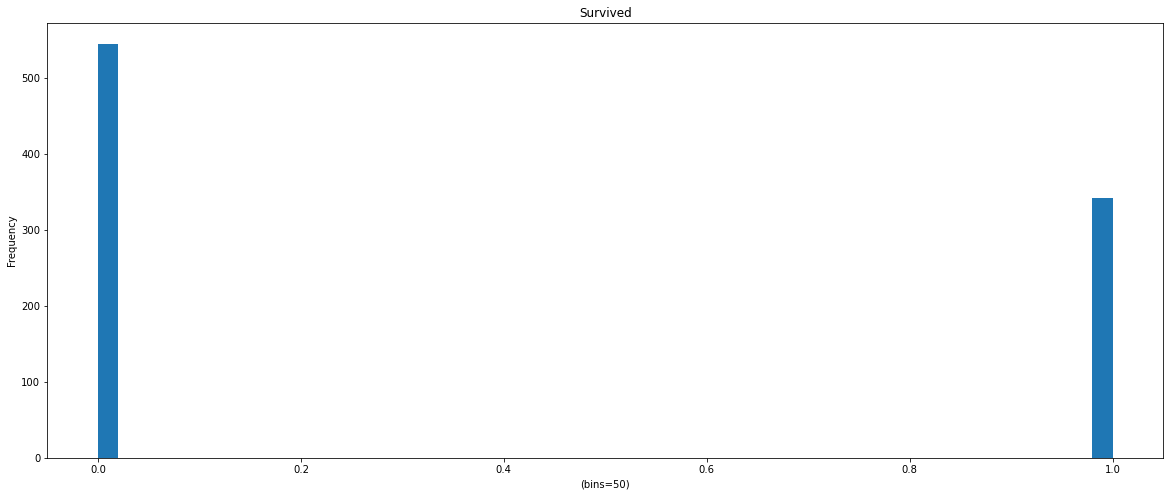

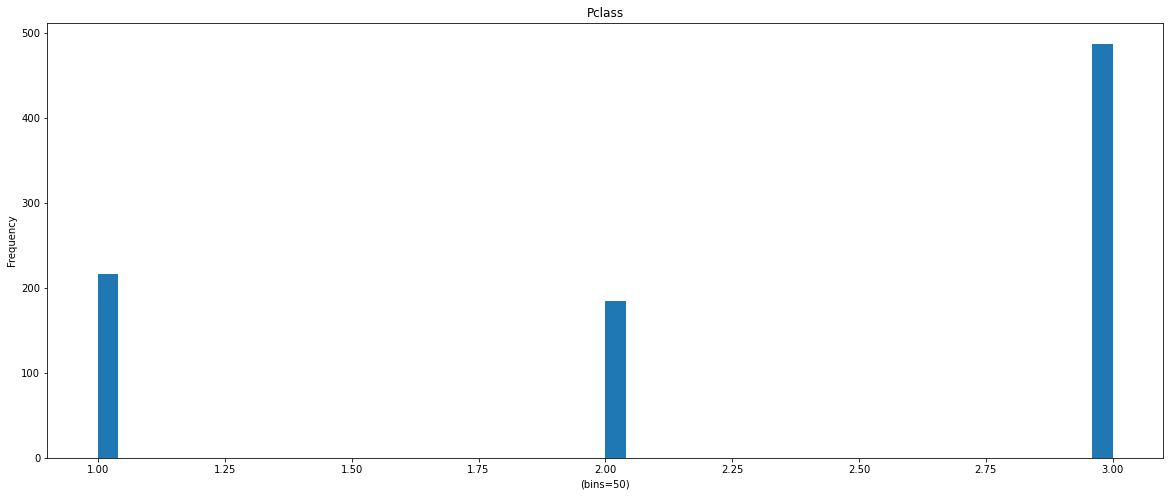

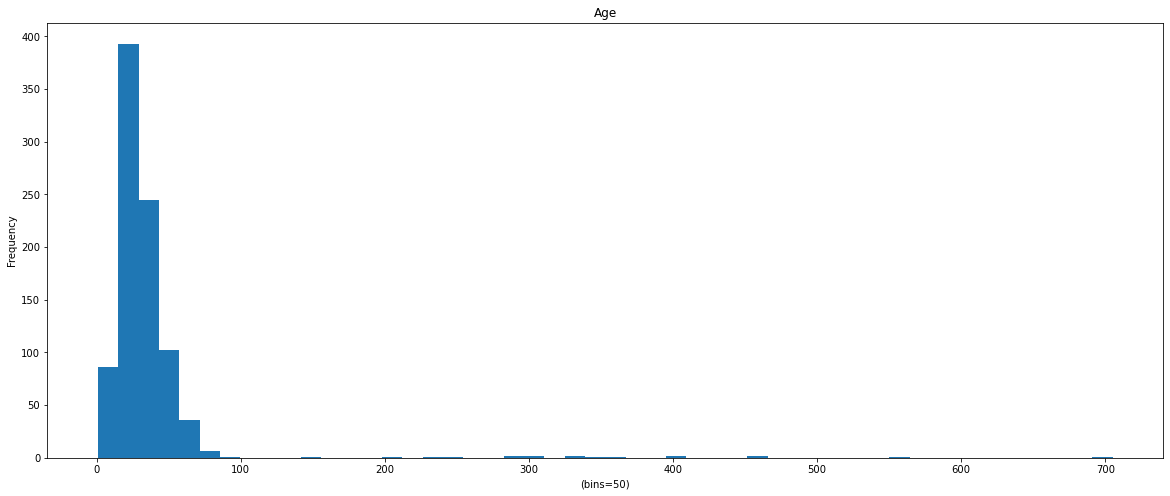

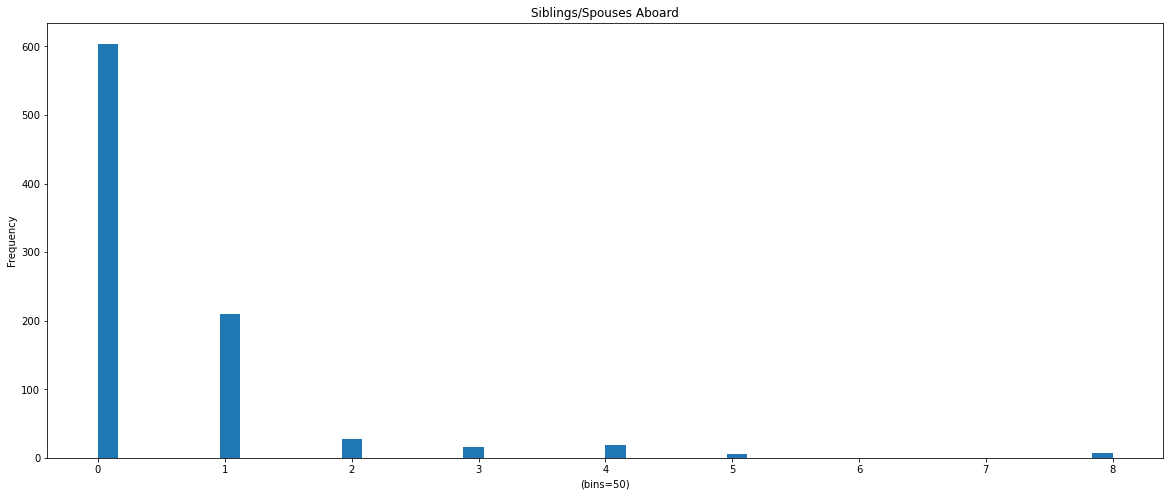

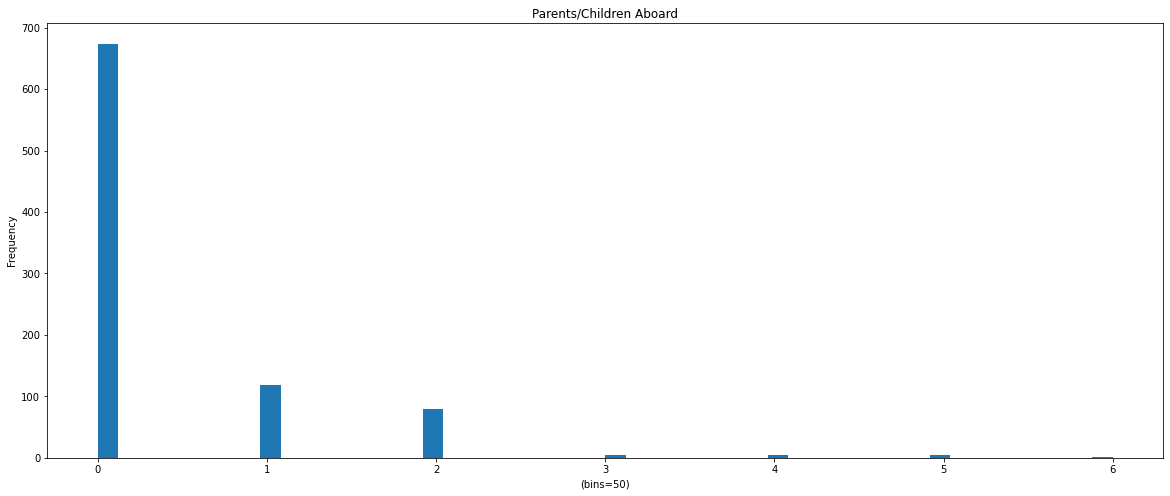

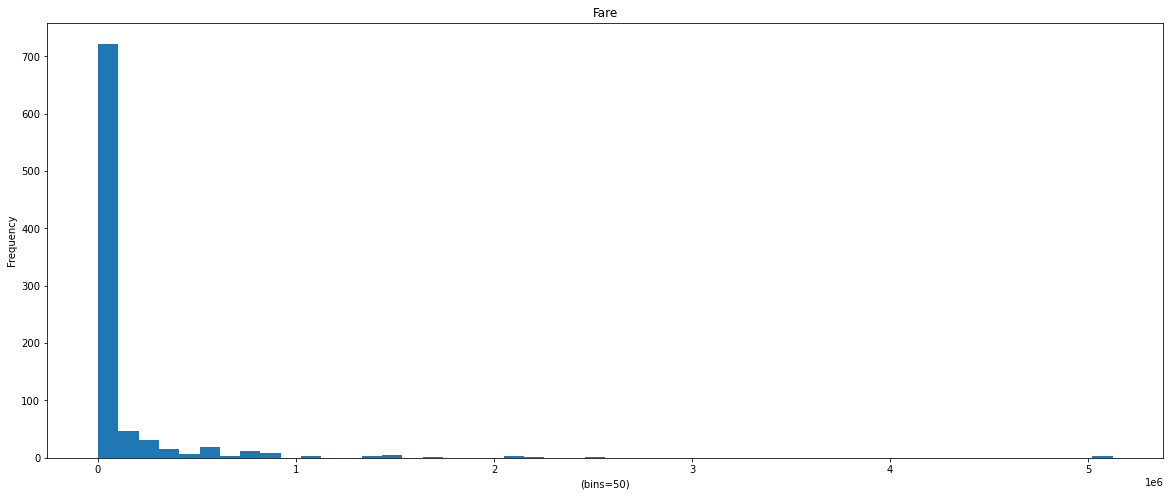

In [85]:
visualizer.plot_hist(df_numeric)

In [107]:
a = {"aa":{"x":1, "y":2},"bb":{"asd":5, "asd":7}}
for a in a.keys():
    print(a)

aa
bb


In [90]:
file_name = "Recommendation_large_STATE.xlsx"
datasets = Path().cwd().parent.parent.parent / "Datasets"
df = pd.read_excel(datasets / file_name)
column_types = {"CLIENTNAME":"categoric", "BRAND":"categoric", "CATEGORY_NAME3":"categoric", "TIMESTAMP":"datetime", "PRICE":"numeric"}
df.head()

,STATE,ACCOUNT_LENGTH,NUMBER_CUSTOMER_SERVICE_CALLS,CHURN,AGE,PRICE,AMOUNT
0,KS,greater_than_100,1_calls,False,24,20.0,10.0
1,OH,greater_than_100,1_calls,False,53,265.0,50.0
2,NJ,greater_than_100,0_calls,False,23,4.0,10.0
3,OH,less_than_100,2_calls,False,24,4.0,10.0
4,OK,less_than_100,3_calls,False,33,4.0,10.0


In [91]:
def plot_bar(df, column):
    count = df.loc[:, column].value_counts()
    names = count.index.values
    values = count.values
    top_limit = 50   
    names_ticks = np.arange(len(names[:top_limit]))
    top_names = names[:top_limit]
    top_values = values[:top_limit]

    title = "Top {top_limit} {column} Counts".format(top_limit=top_limit, column=column)
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize_x, figsize_y)
    bar_plot = ax.bar(top_names, top_values)
    ax.set_ylabel('Counts')
    ax.set_title(title)
    ax.set_xticks(names_ticks)
    ax.set_xticklabels(top_names, rotation=90)
    # "\" or "/" characters caused an exception while saving
    column = column.replace("\\", " ")
    column = column.replace("/", " ")
    image_file = images_dir / "{column}_bar.png".format(column=column)
    fig.savefig(image_file, bbox_inches="tight")
    plt.show()

def plot_pie(dataframe, column):
    df = dataframe.copy()
    df.dropna(inplace=True)
    count = df.loc[:, column].value_counts()
    names = count.index.values
    values = count.values
    top_limit = 20   
    top_names = names[:top_limit]
    top_values = values[:top_limit]
    title = "Top {top_limit} {column} Ratio".format(top_limit=top_limit, column=column)
    fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
    ax.set_title(title)
    # fig.set_size_inches(figsize_x, figsize_y)
    wedges, texts, autotexts = ax.pie(top_values, autopct='%1.1f%%')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.legend(wedges, top_names, title="{0}".format(column), loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    column = column.replace("\\", " ")
    column = column.replace("/", " ")
    image_file = images_dir / "{column}_pie.png".format(column=column)
    fig.savefig(image_file, bbox_inches="tight")
    plt.show()


figsize_x = 12
figsize_y = 8

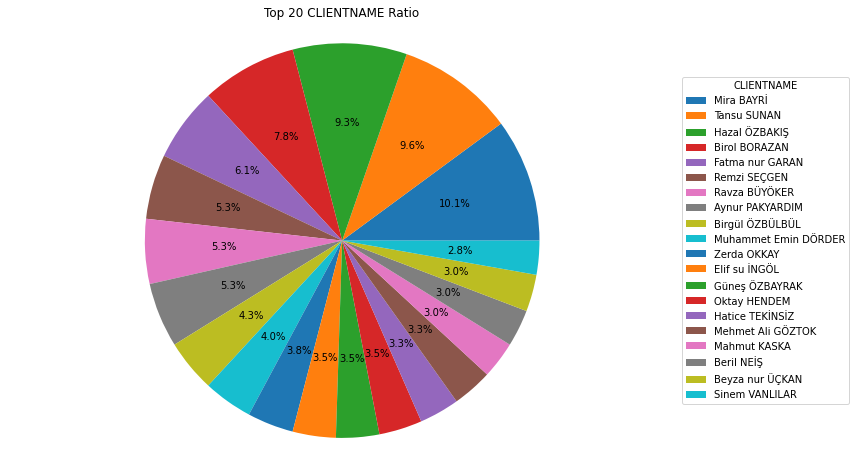

In [64]:
plot_pie(df, "CLIENTNAME")

In [92]:
df.dtypes

STATE                             object
ACCOUNT_LENGTH                    object
NUMBER_CUSTOMER_SERVICE_CALLS     object
CHURN                             object
AGE                                int64
PRICE                            float64
AMOUNT                           float64
dtype: object

In [95]:
df_num = df.select_dtypes(include=["number"])

In [108]:
def plot_histogram( df_numeric, x, bins=50, density=True):
    title = "{X} histogram (bins: {bins} kde: {density})".format(X=x, bins=bins, density=density)
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel(x)
    plt.hist(df_numeric[x], bins=bins, density=True)
    sns.kdeplot(data=df_numeric, x=x)
    name = x.replace("/", " ").replace("\\", " ")
    image_file = Path.joinpath(images_dir, "{name}_histogram.png".format(name=name))
    plt.savefig(image_file, bbox_inches="tight")

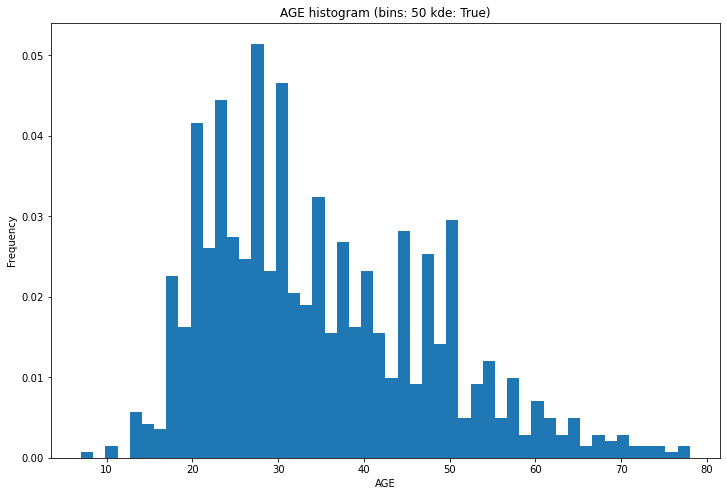

In [109]:
plot_histogram(df_num, "AGE")